### Import libraries

In [1]:
import sys
sys.path.append("../")

In [2]:
import preprocess.view_utils as view_utils

In [3]:
import os
from os import environ
import numpy as np
from random import choices
import pandas as pd
from tqdm.notebook import tqdm

In [4]:
import skimage.io as io
import openslide

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Generate Dataframe with all data info

In [6]:
if environ.get('LVSC_DATA_PATH') is not None:
    PAIP2020_DATA_PATH = environ.get('PAIP2020_DATA_PATH')
else:
    print("Please set the environment variable PAIP2020_DATA_PATH. Read the README!")

In [7]:
msi_h_prediction = pd.read_csv(PAIP2020_DATA_PATH + "Train/annotation/traning_data_MSI.csv")
msi_h_prediction.head()

,WSI_ID,MSI-H Prediction
0,training_data_01,1
1,training_data_02,0
2,training_data_03,0
3,training_data_04,0
4,training_data_05,1


In [8]:
total_cases = 47

In [9]:
validation_frac = 0.15
validation_samples = np.zeros(total_cases)
validation_samples[:int(total_cases*validation_frac)] = 1
np.random.seed(42)
np.random.shuffle(validation_samples)

In [10]:
train_info = []
rootdir = PAIP2020_DATA_PATH + "Train/WSI"
indx = 0
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith(".svs") or file.endswith(".SVS"):
            relative_path_wsi = "Train/WSI/" + file
            relative_path_annotation = "Train/annotation/" + file[:-4] + ".xml"
            relative_path_annotation_tif = "Train/mask_img_l2/" + file[:-4] + "_l2_annotation_tumor.tif"
            is_valid = choices([0, 1], [0.85, 0.15])[0]
            
            train_info.append({
                "wsi":relative_path_wsi, 
                "annotation":relative_path_annotation, 
                "annotation_tif":relative_path_annotation_tif, 
                "MSI-H": msi_h_prediction.loc[msi_h_prediction["WSI_ID"]==file[:-4]]["MSI-H Prediction"].iloc[0],
                "is_validation":validation_samples[indx]
            })
            
            indx+=1
            
train_info = pd.DataFrame(train_info)
train_info.is_validation = train_info.is_validation.astype("int8")
train_info.head()

,wsi,annotation,annotation_tif,MSI-H,is_validation
0,Train/WSI/training_data_41.svs,Train/annotation/training_data_41.xml,Train/mask_img_l2/training_data_41_l2_annotati...,0,0
1,Train/WSI/training_data_38.svs,Train/annotation/training_data_38.xml,Train/mask_img_l2/training_data_38_l2_annotati...,0,0
2,Train/WSI/training_data_36.svs,Train/annotation/training_data_36.xml,Train/mask_img_l2/training_data_36_l2_annotati...,0,0
3,Train/WSI/training_data_10.svs,Train/annotation/training_data_10.xml,Train/mask_img_l2/training_data_10_l2_annotati...,0,0
4,Train/WSI/training_data_08.svs,Train/annotation/training_data_08.xml,Train/mask_img_l2/training_data_08_l2_annotati...,0,0


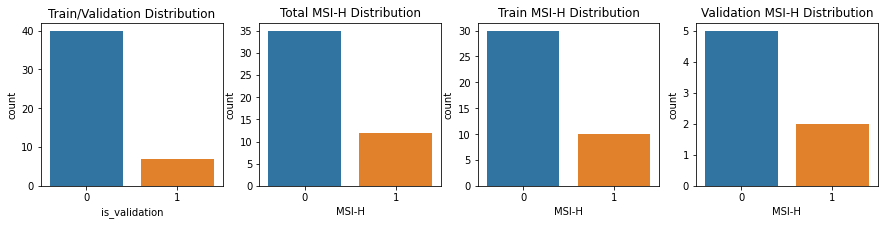

In [11]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(15,3))
#ax1.axis('off'); ax2.axis('off'); ax3.axis('off');
ax0.title.set_text('Train/Validation Distribution')
sns.countplot(train_info["is_validation"], ax=ax0)
ax1.title.set_text('Total MSI-H Distribution')
sns.countplot(train_info["MSI-H"], ax=ax1)
ax2.title.set_text('Train MSI-H Distribution')
sns.countplot(train_info.loc[train_info["is_validation"]==0]["MSI-H"], ax=ax2)
ax3.title.set_text('Validation MSI-H Distribution')
sns.countplot(train_info.loc[train_info["is_validation"]==1]["MSI-H"], ax=ax3)

In [18]:
os.makedirs("../utils/data", exist_ok=True)

In [20]:
train_info.to_csv("../utils/data/train.csv", index=False)

### Explore dataset

#### Load Mask

In [12]:
mask_example = PAIP2020_DATA_PATH + train_info.iloc[0]["annotation_tif"]
mask = view_utils.mask_loader(mask_example, verbose=True)

mask shape: (5816, 7594)


#### Load Whole Image Slide

In [13]:
DISPLAY_LEVEL=2
svs_example = PAIP2020_DATA_PATH + train_info.iloc[0]["wsi"]

In [14]:
wsi_head = openslide.OpenSlide(svs_example)
print("Level dimensions: {}".format(wsi_head.level_dimensions))

Level dimensions: ((121512, 93068), (30378, 23267), (7594, 5816), (3797, 2908))


In [15]:
new_size = (wsi_head.level_dimensions[DISPLAY_LEVEL][1], wsi_head.level_dimensions[DISPLAY_LEVEL][0])
print("New Size Level {}: {}".format(DISPLAY_LEVEL, new_size))

New Size Level 2: (5816, 7594)


In [16]:
slide_img = wsi_head.read_region((0, 0), DISPLAY_LEVEL, wsi_head.level_dimensions[DISPLAY_LEVEL])

In [17]:
full_slide_img = np.asarray(slide_img)
print("Full Slide Shape: {}".format(full_slide_img.shape))
print("Slide Info -> Max: {} / Min: {}".format(full_slide_img.max(), full_slide_img.min()))

Full Slide Shape: (5816, 7594, 4)
Slide Info -> Max: 255 / Min: 9


#### Display Image and Segmentation

In [25]:
save_dir = "../preprocess/overlays/"
os.makedirs(save_dir, exist_ok=True)

In [19]:
overlayed = view_utils.gen_overlay(full_slide_img[..., :3], mask)

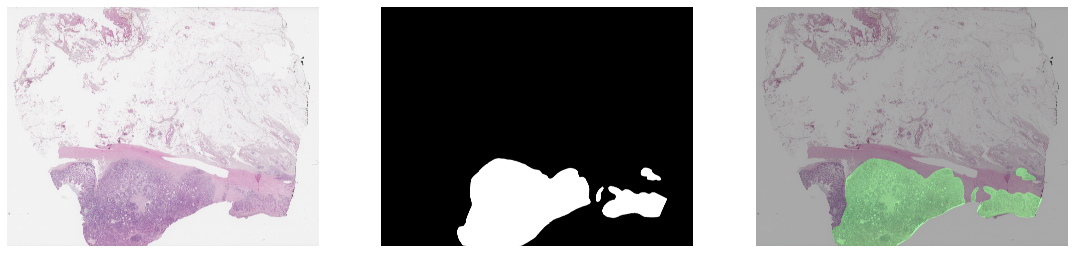

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 19))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off')
ax1.imshow(full_slide_img)
ax2.imshow(mask, cmap="gray")
ax3.imshow(overlayed)

In [21]:
overlay_fit = view_utils.fit_viewer(overlayed)
print("Reduced size. From {} to {}".format(overlayed.shape, overlay_fit.shape))

Reduced size. From (5816, 7594, 3) to (772, 1008, 3)


In [22]:
raw_name = train_info.iloc[0]["wsi"].split("/")[-1][:-4]
print("Case: {}".format(raw_name))

Case: training_data_41


In [23]:
io.imsave('{}overlay_{}.png'.format(save_dir, raw_name), overlay_fit.astype(np.uint8))

### Generate ALL Overlays

In [24]:
for case in tqdm(range(len(train_info))):
    # Load Mask
    mask_example = PAIP2020_DATA_PATH + train_info.iloc[case]["annotation_tif"]
    mask = view_utils.mask_loader(mask_example)
    
    # Load WSI
    svs_example = PAIP2020_DATA_PATH + train_info.iloc[case]["wsi"]
    wsi_head = openslide.OpenSlide(svs_example)
    slide_img = wsi_head.read_region((0, 0), DISPLAY_LEVEL, wsi_head.level_dimensions[DISPLAY_LEVEL])
    full_slide_img = np.asarray(slide_img)
    
    # Generate overlay
    overlayed = view_utils.gen_overlay(full_slide_img[..., :3], mask)
    overlay_fit = view_utils.fit_viewer(overlayed)
    
    # Find case name
    raw_name = train_info.iloc[case]["wsi"].split("/")[-1][:-4]
    
    # Save overlay
    io.imsave('{}overlay_{}.png'.format(save_dir, raw_name), overlay_fit.astype(np.uint8))